# Nonparametric Inference using Control Points 
In this notebook we simulate noisy Δ14C data, from a sinusoidal production rate function, and try to recover the production rates using control points interpolated by a Gaussian Process. 

The control points are first fitted by local optimization, with objective function being the negative chi2 likelihood of the model with a GP regularization term. We then use this to initialize an MCMC sampler to quantify the uncertainties. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ticktack
from ticktack import fitting
import jax.numpy as jnp
from jax import jit
from tqdm import tqdm
plt.rcParams.update({"text.usetex": False})

## Simulating Noisy d14c data

We start by defining a parametric production rate function to simulate data for injection and recovery. For this example, we use a sinusoid with a 11-year period. In the next cell, the attributes for a `SingleFitter` have been defined explicitly. In practice, one can just call `sf.load_data(filename.csv)`, provided the csv file is in the required structure (see `example.csv`).

In [2]:
@jit
def sine(t):
    prod =  1.87 + 0.7 * 1.87 * jnp.sin(2 * jnp.pi / 11 * t + jnp.pi/2)
    prod = prod * (t>=sf.start) + (1.87 + 0.18 * 1.87 * jnp.sin(2 * jnp.pi / 11 * sf.start + jnp.pi/2)) * (1-(t>=sf.start))
    return prod

In [3]:
cbm = ticktack.load_presaved_model('Guttler15', production_rate_units = 'atoms/cm^2/s')
sf = fitting.SingleFitter(cbm, cbm_model='Guttler15')
sf.compile_production_model(model=sine)
sf.time_data = jnp.arange(200, 230) 
sf.d14c_data_error = jnp.ones((sf.time_data.size,))
sf.start = np.nanmin(sf.time_data)
sf.end = np.nanmax(sf.time_data)
sf.annual = jnp.arange(sf.start, sf.end + 1)
sf.oversample = 1008
sf.burn_in_time = jnp.arange(sf.start-2000, sf.start, 1.)
sf.time_data_fine = jnp.linspace(sf.start, sf.end + 2, (sf.annual.size + 1) * sf.oversample)
sf.offset = 0
sf.mask = jnp.in1d(sf.annual, sf.time_data)
sf.growth = sf.get_growth_vector("june-august")

Visualizing true d14c data and noisy d14c data. Adding unit gaussian noise on the d14c data gives SNR ~10.

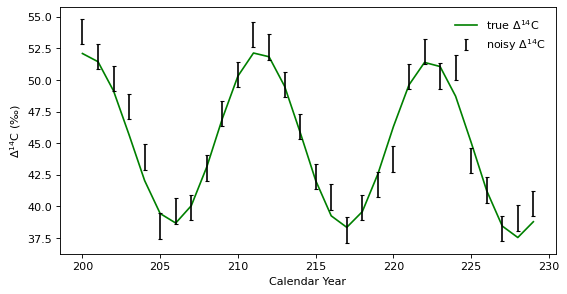

In [4]:
np.random.seed(0)
fig, ax = plt.subplots(figsize=(8, 4), dpi=80)
d14c = sf.dc14()
noisy_d14c = np.array(d14c) + np.random.randn(d14c.size) # add unit gaussian noise
ax.plot(sf.time_data, d14c, "-g", label="true $\Delta^{14}$C", markersize=10)
ax.errorbar(sf.time_data, noisy_d14c, yerr=sf.d14c_data_error, 
             fmt="k", linestyle='none', fillstyle="none", capsize=2, label="noisy $\Delta^{14}$C")
ax.set_ylabel("$\Delta^{14}$C (‰)")
ax.set_xlabel("Calendar Year");
ax.legend(frameon=False);

Here we have the noisy d14c data stored in `sf.d14c_data`. Based on this noisy data, we want to recover the true production rate as best as we can. A non-parametric approach is using control points, which determine the shape of the production function. To avoid long runtime, we use only one control point per 2 years. 

In [5]:
sf.d14c_data = jnp.array(noisy_d14c)
sf.compile_production_model(model="control_points")
sf.control_points_time = jnp.arange(sf.start, sf.end, 2)
print("%d years in the period, %d control-points used" % (sf.annual.size, sf.control_points_time.size))

30 years in the period, 15 control-points used


Fitting the control points using the L-BFGS-B method from `scipy.minimize.optimize`,

In [6]:
%%time
soln = sf.fit_ControlPoints()

CPU times: user 1min 57s, sys: 334 ms, total: 1min 57s
Wall time: 1min 57s


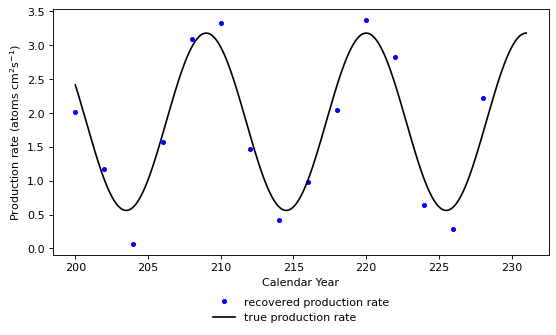

In [7]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=80)
ax.plot(sf.control_points_time, soln.x, ".b", markersize=7, label="recovered production rate")
ax.plot(sf.time_data_fine, sine(sf.time_data_fine), 'k', label='true production rate')
ax.set_ylabel("Production rate (atoms cm$^2$s$^{-1}$)");
ax.set_xlabel("Calendar Year");
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), frameon=False);

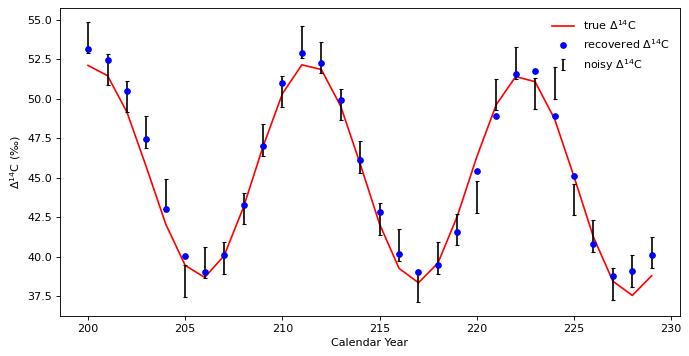

In [8]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=80)
ax.plot(sf.time_data, d14c, "-r", label="true $\Delta^{14}$C", markersize=10)
ax.errorbar(sf.time_data, noisy_d14c, yerr=sf.d14c_data_error,  
            fmt="k", linestyle='none', fillstyle="none", capsize=2, label="noisy $\Delta^{14}$C")
ax.plot(sf.time_data, sf.dc14(soln.x), ".b", label="recovered $\Delta^{14}$C", markersize=10)
ax.set_ylabel("$\Delta^{14}$C (‰)");
ax.set_xlabel("Calendar Year");
ax.legend(frameon=False);

We now use MCMC to sample the posterior distribution for the control points using the affine-invariant sampler `emcee`:

In [9]:
sampler = sf.MarkovChainSampler(soln.x, sf.log_joint_likelihood_gp, burnin=500, 
                                production=500, 
                                args=(np.zeros(soln.x.shape), 
                                     np.ones(soln.x.shape) * 100)
                               )

Running burn-in...


100%|█████████████████████████████████████████| 500/500 [10:21<00:00,  1.24s/it]


Running production...


100%|█████████████████████████████████████████| 500/500 [10:15<00:00,  1.23s/it]


Let's visualize the diversity of samples and quantify the uncertainty on our fitted production rate. We do pretty well! 

100%|███████████████████████████████████████████| 30/30 [00:00<00:00, 89.03it/s]


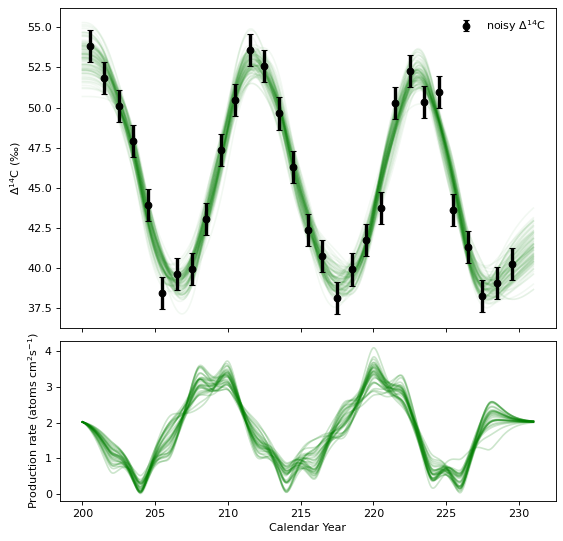

In [10]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]}, dpi=80)
fig.subplots_adjust(hspace=0.05)
plt.rcParams.update({"text.usetex": False})
idx = np.random.randint(len(sampler), size=100)
for param in tqdm(sampler[idx]):
    ax1.plot(sf.time_data_fine, sf.dc14_fine(params=param), alpha=0.05, color="g")

for param in tqdm(sampler[idx][:30]):
    ax2.plot(sf.time_data_fine, sf.production(sf.time_data_fine, *param), alpha=0.2, color="g")

ax1.errorbar(sf.time_data + sf.time_offset, sf.d14c_data, yerr=sf.d14c_data_error, 
             fmt="ok", capsize=3, markersize=6, elinewidth=3, label="noisy $\Delta^{14}$C")
ax1.legend(frameon=False);
ax1.set_ylabel("$\Delta^{14}$C (‰)")
ax2.set_xlabel("Calendar Year");
ax2.set_ylabel("Production rate (atoms cm$^2$s$^{-1}$)");